# I. Importations des modules et des données
## 1.1 Importation des modules

In [58]:
import tensorflow as tf
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from zipfile import ZipFile
import shutil
import glob

## 1.2 Extraction des données

In [59]:
# allow_extraction = False
# datasets_path = r"C:\Users\axelb\Desktop\Projet DS\Datasets"
# extracted_datasets_path = os.path.join(datasets_path,'Extracted')
# new_dataset_filename = "Other"
# new_dataset_path = os.path.join(extracted_datasets_path, new_dataset_filename)
# datasets_to_regroup = ['Dataset','Painting','Schematics','Sketch','Text']

# if allow_extraction:
#     try:
#         for dataset_filename in os.listdir(datasets_path):

#             dataset_path = os.path.join(datasets_path, dataset_filename)
#             dataset_zip = ZipFile(dataset_path, 'r')

#             if not os.path.exists(extracted_datasets_path):
#                 os.makedirs(extracted_datasets_path)
#                 print(f"Extraction folder successfully created at '{extracted_datasets_path}'")

#             print(f"Starting the extraction of '{dataset_filename}' at '{extracted_datasets_path}'")
#             dataset_zip.extractall(extracted_datasets_path)
#             print(f"'{dataset_filename}' was successfully extracted at '{extracted_datasets_path}'")

#         dataset_zip.close()
#     except:
#         pass
    
#     if not os.path.exists(new_dataset_path):
#         os.makedirs(new_dataset_path)
#         print(f"New folder successfully created at '{new_dataset_path}'")
#     for dataset in os.listdir(extracted_datasets_path):
#         if dataset in datasets_to_regroup:
#             dataset_directory = os.path.join(extracted_datasets_path, dataset)
#             print(f"Starting the copy of '{dataset_directory}' at '{new_dataset_path}'")
#             shutil.copytree(dataset_directory, new_dataset_path, copy_function=shutil.move, dirs_exist_ok=True)
#             print(f"'The content of {dataset_directory}' was successfully extracted at '{new_dataset_path}'")
#             shutil.rmtree(dataset_directory)

## 1.3 Pré-traitement des données

### Recherche d'images  corrompues et rotation des images

In [60]:
project_path = r"..\Datasets_test_binary\OneDrive_2022-09-22\Dataset projet"
other_dir = project_path + r"\other"
photo_dir = project_path + r"\photo"

In [61]:
allow_search_for_corrupted = False
bad_paths = []

if allow_search_for_corrupted:
    img_paths = glob.glob(os.path.join(project_path,'*/*.*')) # assuming you point to the directory containing the label folders.

    
    for image_path in img_paths:
        try:
          img_bytes = tf.io.read_file(image_path)
          decoded_img = tf.io.decode_image(img_bytes)
        except tf.errors.InvalidArgumentError as e:
          print(f"Found bad path {image_path}...{e}")
          bad_paths.append(image_path)

    print("BAD PATHS:")
    for bad_path in bad_paths:
        print(f"{bad_path}")

In [62]:
for path in bad_paths:
    try:
        os.remove(path)
    except OSError as error:
        break

## 1.4 Importation des données

In [63]:
train_set, test_set = tf.keras.preprocessing.image_dataset_from_directory(
    project_path,
    validation_split=0.2,
    seed=10,
    image_size = (384, 384),
    batch_size=128,
    subset = "both"
)
print(f"\nThe dataset is composed of these classes : {train_set.class_names}")


Found 41405 files belonging to 2 classes.
Using 33124 files for training.
Using 8281 files for validation.

The dataset is composed of these classes : ['Other', 'Photo']


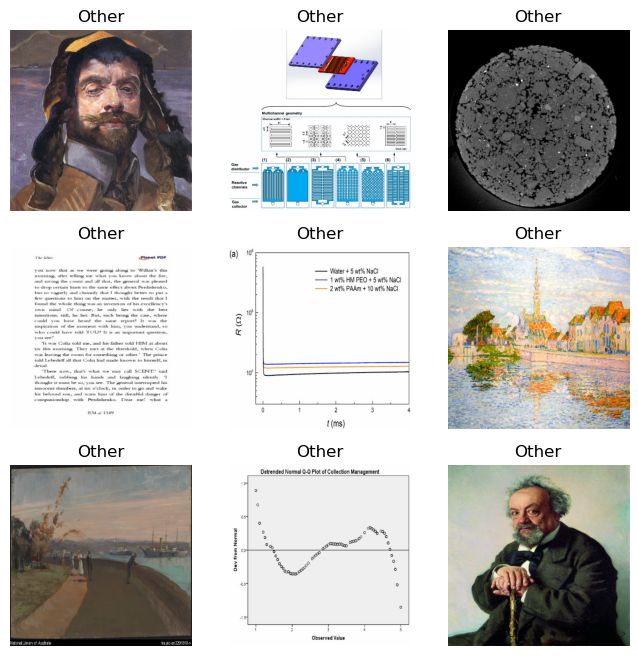

In [64]:
plt.figure(figsize=(8, 8))
for images, labels in train_set.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(train_set.class_names[labels[i]])
        plt.axis("off")
plt.show()

## 1.5 Augmentation des données

# 2. Modélisation des données
## 2.1 Définition du modèle

In [85]:
from tensorflow.keras.applications.efficientnet import EfficientNetB0
from tensorflow import keras
from keras import layers

class OwnEfficientNetB0:  
    @staticmethod
    def build(input_shape, trainable=False, dropout=0.2):
        inputs = keras.Input(shape=input_shape)

        baseModel = EfficientNetB0(weights="imagenet", include_top=False, input_tensor=inputs)
        baseModel.trainable = trainable

        headModel = baseModel.output
        headModel = layers.GlobalAveragePooling2D()(headModel)
        headModel = layers.Dropout(dropout)(headModel)
        outputs = layers.Dense(1, activation="sigmoid")(headModel)
        model = tf.keras.Model(inputs, outputs)

        return model

In [86]:
model = OwnEfficientNetB0().build(input_shape=(384, 384, 3))



In [82]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_12 (InputLayer)          [(None, 384, 384, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_13 (Rescaling)       (None, 384, 384, 3)  0           ['input_12[0][0]']               
                                                                                                  
 normalization_4 (Normalization  (None, 384, 384, 3)  7          ['rescaling_13[0][0]']           
 )                                                                                                
                                                                                              

                                                                                                  
 block2a_project_conv (Conv2D)  (None, 96, 96, 24)   2304        ['block2a_se_excite[0][0]']      
                                                                                                  
 block2a_project_bn (BatchNorma  (None, 96, 96, 24)  96          ['block2a_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block2b_expand_conv (Conv2D)   (None, 96, 96, 144)  3456        ['block2a_project_bn[0][0]']     
                                                                                                  
 block2b_expand_bn (BatchNormal  (None, 96, 96, 144)  576        ['block2b_expand_conv[0][0]']    
 ization)                                                                                         
          

                                                                                                  
 block3b_expand_bn (BatchNormal  (None, 48, 48, 240)  960        ['block3b_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block3b_expand_activation (Act  (None, 48, 48, 240)  0          ['block3b_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block3b_dwconv (DepthwiseConv2  (None, 48, 48, 240)  6000       ['block3b_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block3b_b

 block4b_dwconv (DepthwiseConv2  (None, 24, 24, 480)  4320       ['block4b_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block4b_bn (BatchNormalization  (None, 24, 24, 480)  1920       ['block4b_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block4b_activation (Activation  (None, 24, 24, 480)  0          ['block4b_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block4b_se_squeeze (GlobalAver  (None, 480)         0           ['block4b_activation[0][0]']     
 agePoolin

                                                                                                  
 block5a_activation (Activation  (None, 24, 24, 480)  0          ['block5a_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block5a_se_squeeze (GlobalAver  (None, 480)         0           ['block5a_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block5a_se_reshape (Reshape)   (None, 1, 1, 480)    0           ['block5a_se_squeeze[0][0]']     
                                                                                                  
 block5a_se_reduce (Conv2D)     (None, 1, 1, 20)     9620        ['block5a_se_reshape[0][0]']     
          

                                                                                                  
 block5c_se_expand (Conv2D)     (None, 1, 1, 672)    19488       ['block5c_se_reduce[0][0]']      
                                                                                                  
 block5c_se_excite (Multiply)   (None, 24, 24, 672)  0           ['block5c_activation[0][0]',     
                                                                  'block5c_se_expand[0][0]']      
                                                                                                  
 block5c_project_conv (Conv2D)  (None, 24, 24, 112)  75264       ['block5c_se_excite[0][0]']      
                                                                                                  
 block5c_project_bn (BatchNorma  (None, 24, 24, 112)  448        ['block5c_project_conv[0][0]']   
 lization)                                                                                        
          

 block6b_project_conv (Conv2D)  (None, 12, 12, 192)  221184      ['block6b_se_excite[0][0]']      
                                                                                                  
 block6b_project_bn (BatchNorma  (None, 12, 12, 192)  768        ['block6b_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block6b_drop (Dropout)         (None, 12, 12, 192)  0           ['block6b_project_bn[0][0]']     
                                                                                                  
 block6b_add (Add)              (None, 12, 12, 192)  0           ['block6b_drop[0][0]',           
                                                                  'block6a_project_bn[0][0]']     
                                                                                                  
 block6c_e

 lization)                                                                                        
                                                                                                  
 block6d_drop (Dropout)         (None, 12, 12, 192)  0           ['block6d_project_bn[0][0]']     
                                                                                                  
 block6d_add (Add)              (None, 12, 12, 192)  0           ['block6d_drop[0][0]',           
                                                                  'block6c_add[0][0]']            
                                                                                                  
 block7a_expand_conv (Conv2D)   (None, 12, 12, 1152  221184      ['block6d_add[0][0]']            
                                )                                                                 
                                                                                                  
 block7a_e

In [44]:
# model = tf.keras.Sequential([
#     tf.keras.layers.experimental.preprocessing.Rescaling(1./255, offset=0.0),
#     tf.keras.layers.Conv2D(16, 3, activation='relu'),
#     tf.keras.layers.MaxPooling2D(),
#     tf.keras.layers.Conv2D(32, 3, activation='relu'),
#     tf.keras.layers.MaxPooling2D(),
#     tf.keras.layers.Conv2D(64, 3, activation='relu'),
#     tf.keras.layers.MaxPooling2D(),
#     tf.keras.layers.Flatten(),
#     tf.keras.layers.Dense(128, activation='relu'),
#     tf.keras.layers.Dense(1, activation='sigmoid')
# ])

## 2.2 Compilation du modèle 

In [87]:
model.compile(
    optimizer='adam',
    loss=tf.losses.BinaryCrossentropy(),
    metrics=['accuracy'])

## 2.3 Entrainement du modèle

Epoch 1/10
259/259 [==============================] - 220s 816ms/step - loss: 0.1451 - accuracy: 0.9574 - val_loss: 0.0640 - val_accuracy: 0.9843
Epoch 2/10
259/259 [==============================] - 223s 850ms/step - loss: 0.0562 - accuracy: 0.9851 - val_loss: 0.0434 - val_accuracy: 0.9889
Epoch 3/10
259/259 [==============================] - 299s 1s/step - loss: 0.0440 - accuracy: 0.9883 - val_loss: 0.0353 - val_accuracy: 0.9905
Epoch 4/10
259/259 [==============================] - 219s 831ms/step - loss: 0.0375 - accuracy: 0.9896 - val_loss: 0.0308 - val_accuracy: 0.9911
Epoch 5/10
259/259 [==============================] - 225s 858ms/step - loss: 0.0340 - accuracy: 0.9904 - val_loss: 0.0283 - val_accuracy: 0.9918
Epoch 6/10
259/259 [==============================] - 224s 852ms/step - loss: 0.0312 - accuracy: 0.9911 - val_loss: 0.0262 - val_accuracy: 0.9915
Epoch 7/10
259/259 [==============================] - 222s 847ms/step - loss: 0.0295 - accuracy: 0.9915 - val_loss: 0.0250 - va

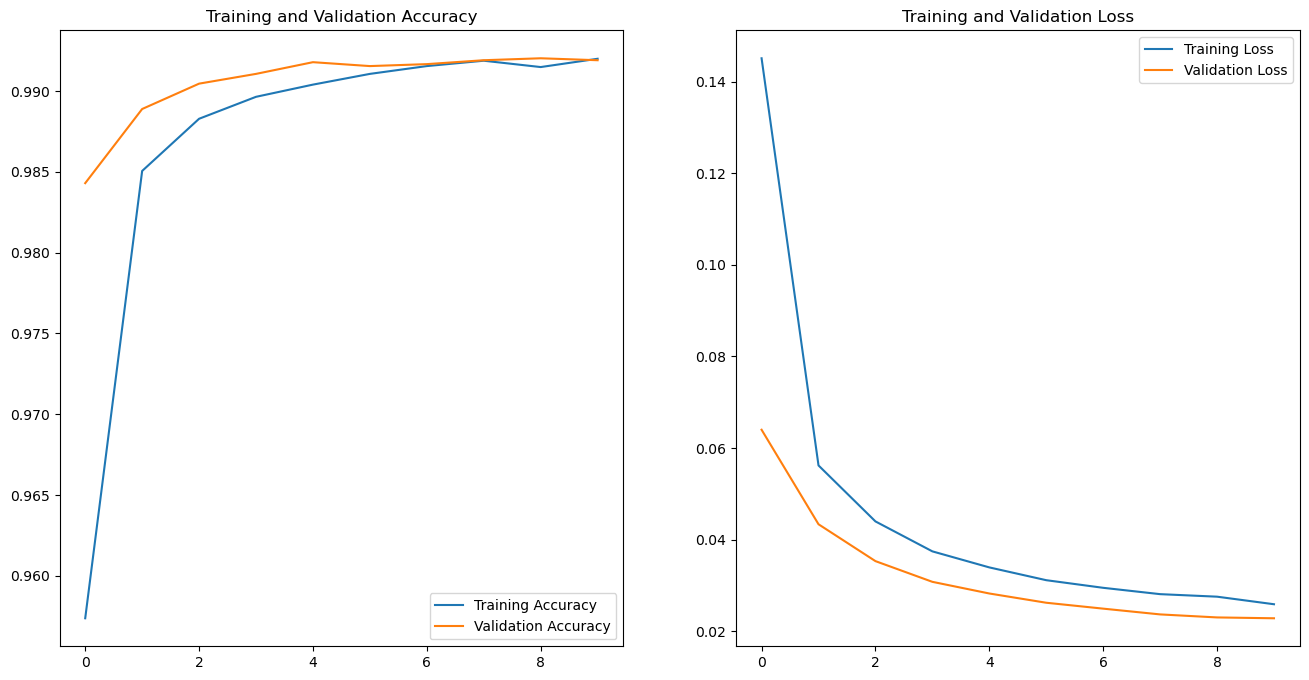

In [88]:
epochs = 10


history =  model.fit(
    train_set,
    validation_data=test_set,
    epochs=epochs
)

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [89]:
from keras.utils import plot_model
plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
